In [1]:
import tensorflow as tf
import tensorflow.keras.layers as ly
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential 
tfds.disable_progress_bar()

In [2]:
embedding_layer = ly.Embedding(1000, 5)

Warstwę Embedding (Osadzanie) można rozumieć jako tabelę wyszukiwania, która mapuje z liczb całkowitych
(tutaj jakieś słowa) od wektorów Dense (ich embeddingi). Wymiarowanie (lub szerokość) embeddingu jest parametrem z którym trzeba eksperymentwać, aby sprawdzić, co działa dobrze w konkretnym przypadku, podobnie jak eksperymentuje się z liczbą neuronów w warstwie Dense.

In [4]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.00385623, -0.00091951,  0.02418509, -0.0091805 ,  0.03494379],
       [ 0.01489735,  0.02064275,  0.04539413, -0.02298254,  0.0055915 ],
       [-0.00100106,  0.01644837, -0.0251384 , -0.01172367,  0.03717365]],
      dtype=float32)

Podczas tworzenia warstwy Embedding wagi są randomowo inicjowane (tak jak kazda inna warstwa). Podczas treningu są stopniowo dostosowywane poprzez backpropagation. Po treningu, embeddingowane słowa będą w przybliżeniu kodować podobieństwa miedzy słowami.
Jeśli przekaże się liczbę całkowitą do warstwy Embedding, wynik zamienia każdą liczbę całkowitą na wektor z tabeli embedding (tak jak to widać wyżej)

In [5]:
(train_data, test_data), info = tfds.load("imdb_reviews/subwords8k", 
                                            split=(tfds.Split.TRAIN, tfds.Split.TEST),
                                            with_info=True, as_supervised=True)

In [6]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

`padded_batch` - standarylizuje długość reviews

In [13]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [15]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[8025,  147,    1, ...,    0,    0,    0],
       [7915, 7961,   80, ...,    0,    0,    0],
       [ 274,    4,   74, ...,    0,    0,    0],
       ...,
       [ 373,    6,    1, ...,    0,    0,    0],
       [ 775, 1069,   34, ...,   63,  166, 7962],
       [2016,  145,  110, ...,    0,    0,    0]], dtype=int64)

In [16]:
embedding_dim = 16

model = Sequential([
    ly.Embedding(encoder.vocab_size, embedding_dim),
    ly.GlobalAveragePooling1D(),
    ly.Dense(16, activation="relu"),
    ly.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

history = model.fit(train_batches, epochs=10, validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.5346 - accuracy: 0.6745 - val_loss: 0.4311 - val_accuracy: 0.7900
Epoch 2/10
2500/2500 [==============================] - 16s 7ms/step - loss: 0.2947 - accuracy: 0.8774 - val_loss: 0.3503 - val_accuracy: 0.8200
Epoch 3/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2382 - accuracy: 0.9052 - val_loss: 0.3685 - val_accuracy: 0.8450
Epoch 4/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2031 - accuracy: 0.9223 - val_loss: 0.4088 - val_accuracy: 0.8350
Epoch 5/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1817 - accuracy: 0.9306 - val_loss: 0.4736 - val_accuracy: 0.8300
Epoch 6/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1646 - accuracy: 0.9390 - val_loss: 0.3810 - val_accuracy: 0.8450
Epoch 7/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1461 - accuracy: 0.9472 - val_loss: 0.4707 - val_ac

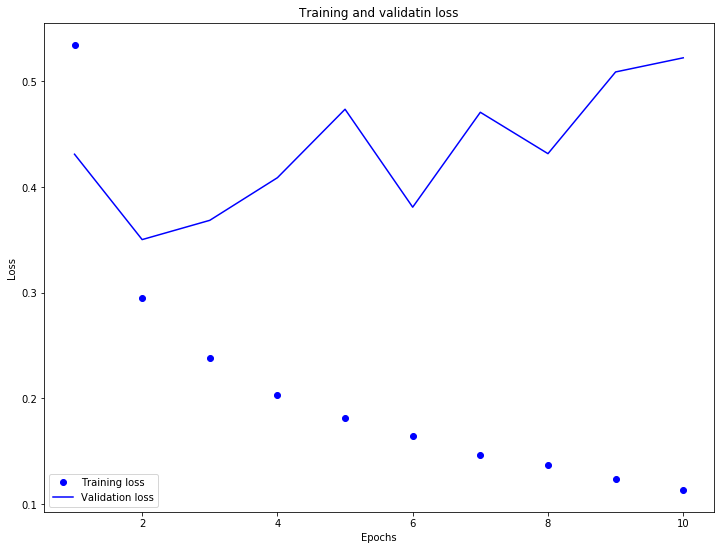

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["accuracy"])+1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, history.history['loss'], 'bo', label="Training loss")
plt.plot(epochs, history.history['val_loss'], 'b', label="Validation loss")
plt.title('Training and validatin loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

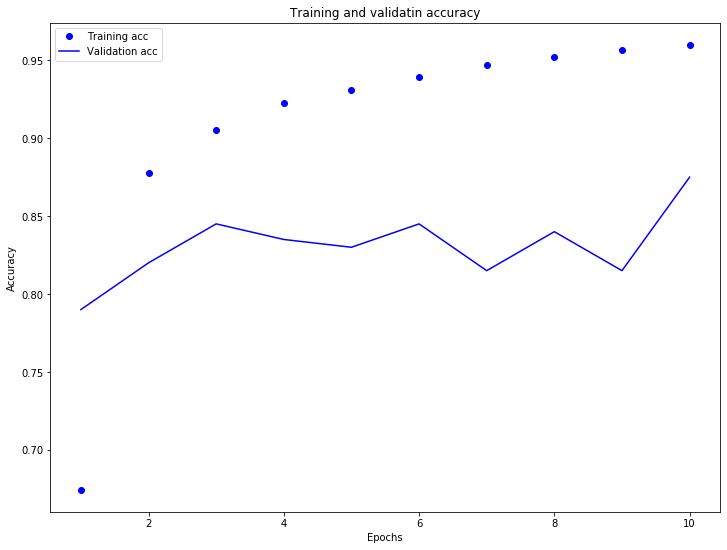

In [20]:
plt.figure(figsize=(12, 9))
plt.plot(epochs, history.history['accuracy'], 'bo', label="Training acc")
plt.plot(epochs, history.history['val_accuracy'], 'b', label="Validation acc")
plt.title('Training and validatin accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# RETRIEVING THE LEARNED EMBEDDINGS

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [25]:
import io

encoder = info.features['text'].encoder

v = io.open('vecs.tsv', 'w', encoding='utf-8')
m = io.open('meta.tsv', 'w', encoding='utf-8')

In [26]:
for num, word in enumerate(encoder.subwords):
    vec = weights[num+1]
    m.write(word + "\n")
    v.write('\t'.join([str(x) for x in vec]) + "\n")
v.close()
m.close()